In [13]:
import mne

from crosspy.core.methods import cplv, cplv_pairwise
from crosspy.preprocessing.seeg.support import clean_montage, drop_monopolar_channels
from crosspy.preprocessing.seeg.seeg_utils import create_reference_mask, get_electrode_distance
from crosspy.preprocessing.signal import preprocess_data_morlet

import os

import numpy as np
import glob

import matplotlib.pyplot as plt

import scipy as sp
import scipy.cluster

import sklearn
from sklearn import metrics

import re
import pandas as pd

import pickle

import tqdm

from bids import BIDSLayout

from collections import defaultdict

from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from nihon_reader import RawNihon

In [14]:
from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.166, 0.43, 0.43),
                   (0.33, 0.7, 0.7),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0, 0.6, 0.6)),

         'green': ((0.0, 0.4, 0.4),
                   (0.166, 0.7, 0.7),
                   (0.33, 0.8, 0.8),
                   (0.5, 1.0, 1.0),
                   (0.66, 0.8, 0.8),
                   (1.0,0.0, 0.0)),

         'blue':  ((0.0, 0.8, 0.8),
                   (0.166, 1.0, 1.0),
                   (0.33, 1.0, 1.0),
                   (0.5, 0.4, 0.4),
                   (0.66, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }

ripples_cmap = LinearSegmentedColormap('ripplescmap', cdict1)

In [15]:
def get_frequencies():
    return np.load('gabriele/frequencies.npy')

def get_spectrum(fname, ez_mask):
    res_dict = pickle.load(open(fname, 'rb'))
    data = res_dict['cplv_spectrum']
    mask = np.logical_and(res_dict['reference_mask'].astype(bool), ez_mask)

    plv_spectrum = np.abs(data[:, mask]).mean(axis=1)
    iplv_spectrum = np.abs(np.imag(data[:, mask])).mean(axis=1)
    
    return plv_spectrum, iplv_spectrum

In [16]:
def get_replacement_map(labels_x, labels_y, n_clusters):
    def _cluster_similarity(x_idx, y_idx):
        return 1 - sp.spatial.distance.jaccard(labels_x == x_idx,  labels_y == y_idx)

    sim_matrix = np.zeros((n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            sim_matrix[i,j] = _cluster_similarity(i, j)
    
    return {source:target for source, target in zip(*sp.optimize.linear_sum_assignment(-1*sim_matrix))}

def label_independent_similarity(labels_x, labels_y, n_clusters):
    labels_normalizer = get_replacement_map(labels_x, labels_y, n_clusters)
    labels_x_normed = np.array([labels_normalizer[l] for l in labels_x])
    
    return np.mean(labels_x_normed == labels_y)

In [17]:
df = pd.read_csv('../seeg_phases/data/SEEG_redux_BIDS/convert_results.csv')
df_num_idx = df.set_index('subject_number')

header=['subject', 'contact', 'EZ', 'GMPI']
ez_data = pd.read_csv('202001_SEEG_ripple_Cohort_Contacts.csv', sep=';', header=None)
ez_grouped = ez_data.groupby(0)

subject_to_cluster = pd.read_csv('Subject_agg_cluster_labels.csv').set_index('subject_number')

In [18]:
def create_ez_mask(ez_chans):
    res = np.zeros((ez_chans.shape[0], ez_chans.shape[0]), dtype=bool)
    for i in range(ez_chans.shape[0]):
        for j in range(ez_chans.shape[0]):
            res[i,j] = ez_chans[i] == 0 and ez_chans[j] == 0
    
    return res

def is_bipolar(x):
    a, c = x.split('-')
    
    return len(c) > 0

In [19]:
distance_bins = [0,  32,  45,  60, 137]
frequencies = get_frequencies()

In [20]:
# def get_spectrum_by_bins(data, ez_mask, distance_matrix):
#     ref_mask = data['reference_mask'].astype(bool)
#     spectrum = data['cplv_spectrum']
    
#     n_bins = len(distance_bins) - 1
#     dists_binned = np.digitize(distance_matrix, bins=distance_bins) - 1
    
#     plv_binned = np.zeros((n_bins, spectrum.shape[0]))
#     iplv_binned = np.zeros((n_bins, spectrum.shape[0]))
    
#     for bin_idx in range(n_bins):
#         bin_mask = (dists_binned == bin_idx)

#         mask = np.triu(ref_mask & ez_mask & bin_mask, 1)

#         plv_binned[bin_idx] = np.abs(spectrum[:, mask]).mean(axis=1)
#         iplv_binned[bin_idx] = np.abs(np.imag(spectrum[:, mask])).mean(axis=1)
    
#     return plv_binned, iplv_binned

def get_spectrum_by_bins(data, ez_mask, distance_matrix):
    ref_mask = data['reference_mask'].astype(bool)
    spectrum = data['cplv_spectrum']
    surrogate_spectrum = data['surrogate_spectrum']
    
    n_bins = len(distance_bins) - 1
    dists_binned = np.digitize(distance_matrix, bins=distance_bins) - 1
    
    plv_binned = np.zeros((n_bins, spectrum.shape[0]))
    iplv_binned = np.zeros((n_bins, spectrum.shape[0]))
    plv_k = np.zeros((n_bins, spectrum.shape[0]))
    iplv_k = np.zeros((n_bins, spectrum.shape[0]))
    
    for bin_idx in range(n_bins):
        bin_mask = (dists_binned == bin_idx)
        
        mask = np.triu(ref_mask & ez_mask & bin_mask, 1)

        plv_masked = np.abs(spectrum[:, mask])
        iplv_masked = np.abs(np.imag(spectrum[:, mask]))
            
        plv_surr_values = np.abs(surrogate_spectrum[:,mask]).mean(axis=1, keepdims=True)*3.52
        iplv_surr_values = np.abs(np.imag(surrogate_spectrum[:,mask])).std(axis=1, keepdims=True)*3.52
        
        plv_binned[bin_idx] = plv_masked.mean(axis=1)
        iplv_binned[bin_idx] = iplv_masked.mean(axis=1)
        
        plv_k[bin_idx] = np.mean(plv_masked >= plv_surr_values, axis=1)
        iplv_k[bin_idx] = np.mean(iplv_masked >= iplv_surr_values, axis=1)
    
    return plv_binned, iplv_binned, plv_k, iplv_k

In [21]:
# custom_montage = pd.DataFrame({'name': subj_ez.index.values})

# anode, cathode = zip(*custom_montage['name'].apply(lambda x: x.split('-')).tolist())

# custom_montage[['anode', 'cathode']] = pd.DataFrame([anode, cathode]).T
# custom_montage.to_csv(montage_filename, sep='\t', index=False)

In [22]:
res_data['analysis_parameters']

{'omega': 7.5,
 'lowpass_filter': 440,
 'data_path': '../seeg_phases/data/SEEG_redux_BIDS',
 'output_path': 'derivatives/plv_spectrum_bipolar_good',
 'epleptic_windows_file': 'epleptic_windows.csv',
 'pure_bipolar': False}

In [28]:
plv_spectrum = list()
iplv_spectrum = list()

surr_plv = list()
surr_iplv = list()

plv_spectrum_binned = list()
iplv_spectrum_binned = list()
plv_k_binned = list()
iplv_k_binned = list()

subject_numbers = list()

root_path = os.path.join('../seeg_phases/data', 'SEEG_redux_BIDS')
layout = BIDSLayout(root_path)

for subject in tqdm.tqdm_notebook(layout.get(target='subject', extension='edf')): 
    subj_num = int(subject.entities['subject'])
    subj_name = df_num_idx.loc[subj_num]['name']
    subj_ez = ez_grouped.get_group(subj_name).set_index(1)
    
    if subj_num in {36,13, 14, 40, 42, 47}:
        continue
    
    res_fname = 'derivatives/plv_spectrum_bipolar_good/sub-{}_spectrum_bipolar_ref.pickle'.format(subject.entities['subject'])
    montage_filename = os.path.join(subject.dirname,  'sub-{}_montage_bipolar.csv'.format(subject.entities['subject']))
    electrodes_filename = os.path.join(subject.dirname,  'sub-{}_electrodes.tcsv'.format(subject.entities['subject']))
    
    res_data = pickle.load(open(res_fname, 'rb'))
    
    ref_mask = res_data['reference_mask'].astype(bool)
    
    montage = pd.read_csv(montage_filename, sep='\t')
    montage = montage[montage['name'].apply(is_bipolar)]
    ch_names = montage['name'].values
    
#     electrodes = pd.read_csv(electrodes_filename, sep='\t')
#     distance_matrix = get_electrode_distance(ch_names, electrodes_filename)
    distance_matrix = res_data['electrodes_distance']
    distance_mask = (distance_matrix >= distance_bins[1]) & ref_mask
        
#     ez_chans = np.array([int(subj_ez.loc[ch][2] != 0) for ch in ch_names])
#     ez_mask = create_ez_mask(ez_chans)
  
    ez_mask = np.ones_like(ref_mask, dtype=bool)
    subj_plv_binned, subj_iplv_binned, subj_plv_k, subj_iplv_k = get_spectrum_by_bins(res_data, ez_mask, distance_matrix)
    
    subj_plv, subj_iplv = get_spectrum(res_fname, ez_mask)
        
    if any(np.isnan(subj_plv)):
        print('Subject {} is weird (all chans are ez!)'.format(subj_num))
        continue

    plv_spectrum.append(subj_plv)
    iplv_spectrum.append(subj_iplv)
    subject_numbers.append(subj_num)
    plv_spectrum_binned.append(subj_plv_binned)
    iplv_spectrum_binned.append(subj_iplv_binned)
    plv_k_binned.append(subj_plv_k)
    iplv_k_binned.append(subj_iplv_k)
    surr_plv.append(np.abs(res_data['surrogate_spectrum'][:, ref_mask]).mean(axis=1))
    surr_iplv.append(np.abs(np.imag(res_data['surrogate_spectrum'][:, ref_mask])).mean(axis=1))
    
plv_spectrum = np.array(plv_spectrum)
iplv_spectrum = np.array(iplv_spectrum)

plv_spectrum_binned = np.array(plv_spectrum_binned)
iplv_spectrum_binned = np.array(iplv_spectrum_binned)

plv_k_binned =  np.array(plv_k_binned)
iplv_k_binned = np.array(iplv_k_binned)

surr_iplv = np.array(surr_iplv)
surr_plv = np.array(surr_plv)

/home/vladka/anaconda3/envs/sync_states/lib/python3.6/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater_equal


In [29]:
def estimate_surrogate(data_x, data_y, N_boots=1000):
    n_samples = data_x.shape[0]
    idx = np.arange(n_samples)
    
    coeffs = np.zeros(N_boots)
    
    for round_idx in tqdm.tnrange(N_boots, leave=False):
        np.random.shuffle(idx)
#         coeffs[round_idx] = sp.stats.pearsonr(data_x[idx], data_y)[0]
        coeffs[round_idx] = pg.corr(data_x[idx], y=data_y, method='percbend')['r'].values[0]
    
    return coeffs

def estimate_bootstrapping(data_x, data_y, N_boots = 1000):
    n_samples = data_x.shape[0]
    idx = np.arange(n_samples)
    
    coeffs = np.zeros(N_boots)
    
    for round_idx in tqdm.tnrange(N_boots, leave=False):
        boot_idx = np.random.choice(idx, size=n_samples)
#         coeffs[round_idx] = sp.stats.pearsonr(data_x[boot_idx], data_y[boot_idx])[0]
        coeffs[round_idx] = pg.corr(data_x[boot_idx], data_y[boot_idx], method='percbend')['r'].values[0]
    
    return coeffs

In [30]:
labels_agg = np.array([subject_to_cluster.loc[n]['subject_cluster'] for n in subject_numbers]) - 1
n_clusts_agg = len(set(labels_agg))

In [31]:
lbl_to_color = {0: ripples_cmap(0), 1: ripples_cmap(0.2), 2:ripples_cmap(0.65), 3:ripples_cmap(0.85), 4:ripples_cmap(0.99)}

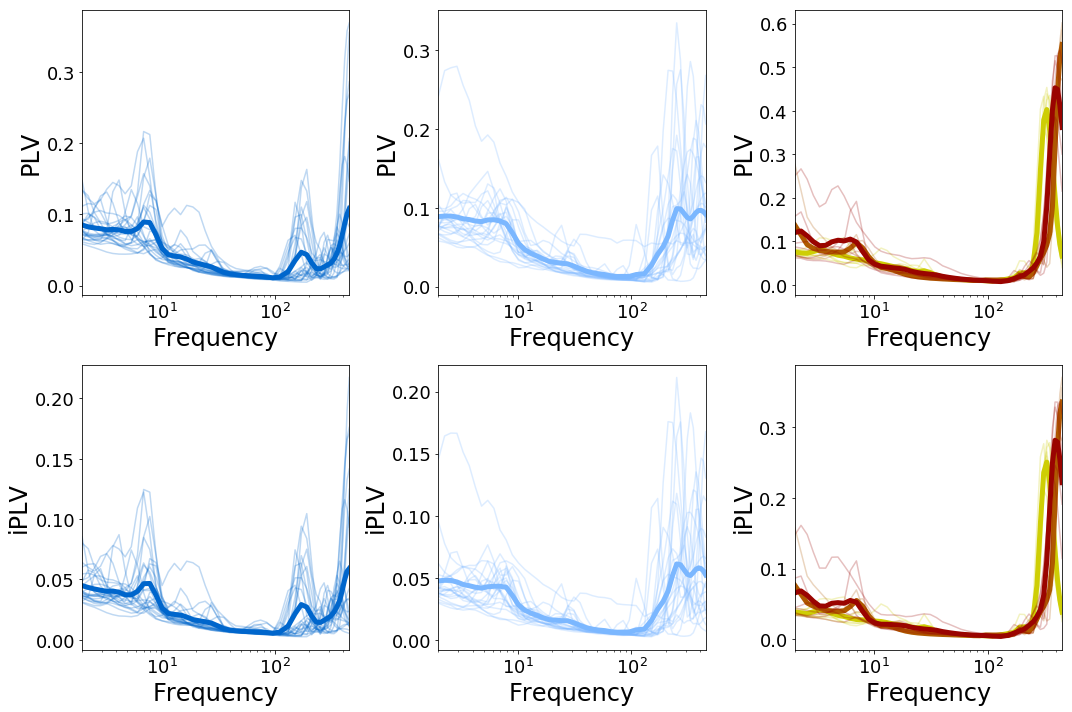

In [32]:
fig, axes = plt.subplots(figsize=(15,10), nrows=2, ncols=3)

for cluster_label, color in zip(range(n_clusts_agg), ['g', 'r', 'cyan', 'magenta', 'orange']):
#     if cluster_label == 3:
#         color = ripples_cmap(0.99)
#     else:
#         color = 'gray'

    ripples_color = [int(v*255) for v in lbl_to_color[cluster_label][:3]]
    color = '#{:02x}{:02x}{:02x}'.format(*ripples_color)

    clust_idx = (labels_agg == cluster_label)
    
    avg_plv_spectrum = plv_spectrum[clust_idx].mean(axis=0)
    avg_iplv_spectrum = iplv_spectrum[clust_idx].mean(axis=0)
    
    if cluster_label == 0:
        ax_idx = 0
    elif cluster_label == 1:
        ax_idx = 1
    else:
        ax_idx = 2
        
    ax_row = axes[:, ax_idx]
    
    ax_row[0].semilogx(frequencies, plv_spectrum.T[:, clust_idx], color=color, alpha=0.25)
    ax_row[0].semilogx(frequencies, avg_plv_spectrum, color=color, lw=5)
    ax_row[0].set_xlabel('Frequency', fontsize=24)
    ax_row[0].set_ylabel('PLV', fontsize=24)
    
#     ax_row[0].set_ylim([0, np.max(plv_spectrum)])
#     ax_row[0].set_ylim([0, np.max(plv_spectrum)])
    
    ax_row[1].semilogx(frequencies, iplv_spectrum.T[:, clust_idx], color=color, alpha=0.25)
    ax_row[1].semilogx(frequencies, avg_iplv_spectrum, color=color, lw=5)
    ax_row[1].set_xlabel('Frequency', fontsize=24)
    ax_row[1].set_ylabel('iPLV', fontsize=24)
    
#     ax_row[1].set_ylim([0, np.max(iplv_spectrum)])
#     ax_row[1].set_ylim([0, np.max(iplv_spectrum)])    

for ax in axes.flatten():
    ax.tick_params(labelsize=18)
    ax.set_xlim([frequencies[0], frequencies[~0]])
    
fig.tight_layout()
fig.savefig('clusters_PLV_bipolar.pdf')

In [33]:
def bootstrap_mean(data, N_boots=100, percentiles=(2.5, 97.5)):
    all_indices = np.arange(data.shape[0])
    
    bootstrap_samples = np.zeros((N_boots, data.shape[1]))
    
    for idx in range(N_boots):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        bootstrap_samples[idx] = data[round_indices].mean(axis=0)
    
    return np.percentile(bootstrap_samples, percentiles, axis=0)

def anova_bootstrapped_bins(data, N_boots=100, percentiles=(2.5, 97.5)):
    all_indices = np.arange(data.shape[0])
    n_bins = data.shape[1]
    
    bootstrap_samples = np.zeros((n_bins, N_boots, data.shape[2]))
    
    for bin_idx in range(n_bins):
        for idx in range(N_boots):
            round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
            bootstrap_samples[bin_idx, idx] = data[round_indices, bin_idx].mean(axis=0)
            
    anova_res = sp.stats.f_oneway(*[bootstrap_samples[bin_idx] for bin_idx in range(n_bins)])
    
    return multipletests(anova_res.pvalue, method='bonferroni')[1]

In [34]:
# all_indices = np.arange(iplv_spectrum_binned.shape[0])
# n_bins = iplv_spectrum_binned.shape[1]

# bootstrap_samples = np.zeros((n_bins, 100, iplv_spectrum_binned.shape[2]))

# for bin_idx in range(n_bins):
#     for idx in range(100):
#         round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
#         bootstrap_samples[bin_idx, idx] = iplv_spectrum_binned[round_indices, bin_idx].mean(axis=0)
        
# anova_res = sp.stats.f_oneway(*[bootstrap_samples[bin_idx] for bin_idx in range(n_bins)])
# corrected = multipletests(anova_res.pvalue, method='bonferroni')[1]

In [35]:
def estimate_mean_with_bootstrap(spectrum, N_rounds=1000):
    all_indices = np.arange(spectrum.shape[0])
        
    res = np.zeros((N_rounds, ) + spectrum.shape[1:])
    for idx in range(N_rounds):
        round_indices = np.random.choice(all_indices, size=all_indices.shape[0])
        res[idx] = spectrum[round_indices].mean(axis=0)
        
    return res

In [36]:
plv_bootstrapped = estimate_mean_with_bootstrap(plv_spectrum_binned, N_rounds=10000)
iplv_bootstrapped = estimate_mean_with_bootstrap(iplv_spectrum_binned, N_rounds=10000)
# plv_bootstrapped = estimate_median_with_bootstrap(plv_spectrum, N_rounds=10000)
# iplv_bootstrapped = estimate_median_with_bootstrap(iplv_spectrum, N_rounds=10000)

plv_k_bootstrapped = estimate_mean_with_bootstrap(plv_k_binned, N_rounds=10000)
iplv_k_bootstrapped = estimate_mean_with_bootstrap(iplv_k_binned, N_rounds=10000)

plv_25, plv_75 = np.percentile(plv_bootstrapped, (5, 95), axis=0)
iplv_25, iplv_75 = np.percentile(iplv_bootstrapped, (5, 95), axis=0)

plv_k_25, plv_k_75 = np.percentile(plv_k_bootstrapped, (5, 95), axis=0)
iplv_k_25, iplv_k_75 = np.percentile(iplv_k_bootstrapped, (5, 95), axis=0)

# surr_plv_lvl = np.mean(surr_plv, axis=0)
# surr_iplv_lvl = np.mean(surr_iplv, axis=0)
surr_plv_lvl = estimate_mean_with_bootstrap(surr_plv).mean(axis=0)
surr_iplv_lvl = estimate_mean_with_bootstrap(surr_iplv).mean(axis=0)

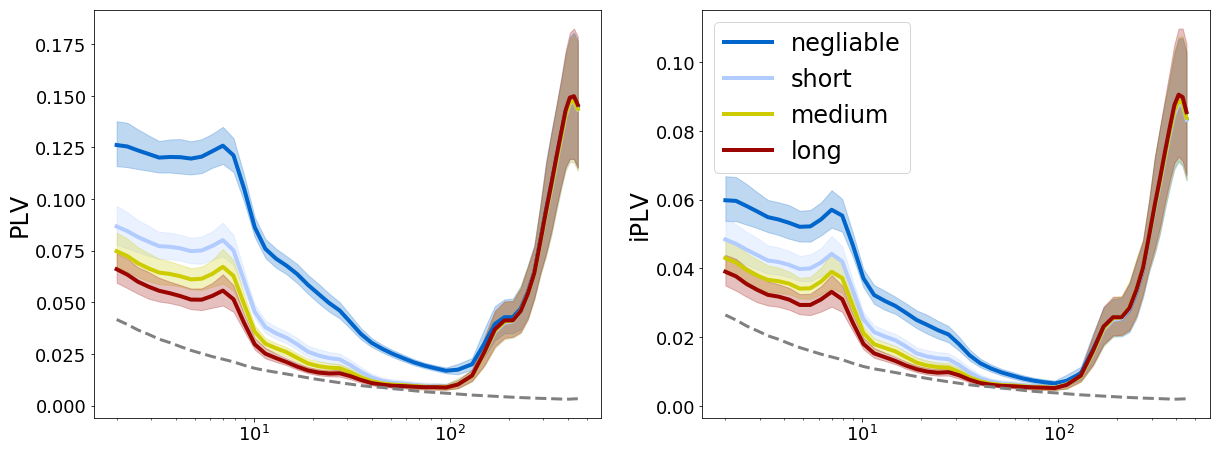

In [37]:
fig, axes = plt.subplots(figsize=(20, 7.5), ncols=2)

colors = [ripples_cmap(0), ripples_cmap(0.33), ripples_cmap(0.66), ripples_cmap(0.99)]
# colors = ['green', 'yellow', 'orange', 'red']

for bin_idx, color, label in zip([0,1,2, 3], colors, ['negliable', 'short', 'medium', 'long']):   
    axes[0].semilogx(frequencies, plv_spectrum_binned[:,bin_idx].mean(axis=0), color=color, lw=4, label=label)
    axes[0].fill_between(frequencies, plv_25[bin_idx], plv_75[bin_idx], color=color, alpha=0.25)
    
    axes[1].semilogx(frequencies, iplv_spectrum_binned[:, bin_idx].mean(axis=0), color=color, lw=4, label=label)
    axes[1].fill_between(frequencies, iplv_25[bin_idx], iplv_75[bin_idx], color=color, alpha=0.25)

axes[0].semilogx(frequencies, surr_plv_lvl, color='gray', ls='--', lw=3)
axes[1].semilogx(frequencies, surr_iplv_lvl, color='gray', ls='--', lw=3)

# axes[0].legend(fontsize=24)
axes[1].legend(fontsize=24)

axes[0].set_ylabel('PLV', fontsize=24)
axes[1].set_ylabel('iPLV', fontsize=24)

for ax in axes:
    ax.tick_params(labelsize=18)
    
fig.savefig('fig_plv_bipolar.svg', dpi=300)

In [20]:
saline = np.load('data/saline_solution.npy')
saline, saline_surr  = saline[...,0], saline[...,1]

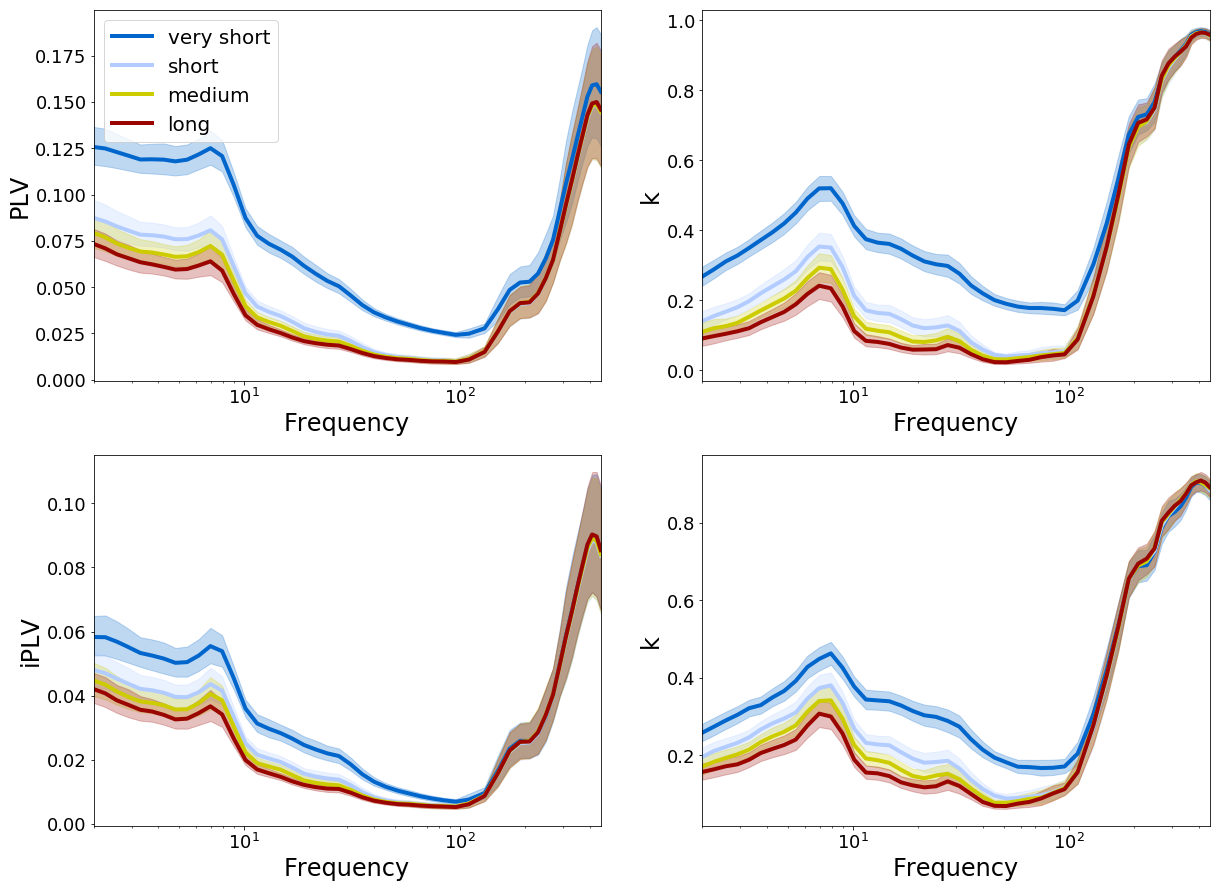

In [43]:
fig, axes = plt.subplots(figsize=(20,15), ncols=2, nrows=2)

for bin_idx, name, color in zip([0,1,2,3], ['very short', 'short', 'medium', 'long'], colors):
    axes[0,0].semilogx(frequencies, plv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0,0].fill_between(frequencies, plv_25[bin_idx], plv_97[bin_idx], color=color, alpha=0.25)
    
    axes[0,1].semilogx(frequencies, plv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[0,1].fill_between(frequencies, plv_k_25[bin_idx], plv_k_97[bin_idx], color=color, alpha=0.25)
    
# axes[0,0].semilogx(frequencies, surr_plv_lvl, ls='--', color='gray', lw=4)
    
for ax, label in zip(axes[0], ['PLV', 'k']):
    ax.set_ylabel(label, fontsize=24)
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)
    
axes[0,0].legend(fontsize=20)

for bin_idx, name, color in zip([0,1,2,3], ['very short', 'short', 'medium', 'long'], colors):
    axes[1,0].semilogx(frequencies, iplv_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[1,0].fill_between(frequencies, iplv_25[bin_idx], iplv_97[bin_idx], color=color, alpha=0.25)
    
    axes[1,1].semilogx(frequencies, iplv_k_bootstrapped[:,bin_idx].mean(axis=0), color=color, label=name, lw=4)
    axes[1,1].fill_between(frequencies, iplv_k_25[bin_idx], iplv_k_97[bin_idx], color=color, alpha=0.25)
    
# axes[1,0].semilogx(frequencies, surr_iplv_lvl, ls='--', color='gray', lw=4)
# axes[1,0].legend(fontsize=20)
for ax, label in zip(axes[1], ['iPLV', 'k']):
    ax.set_ylabel(label, fontsize=24)
    ax.set_xlabel('Frequency', fontsize=24)
    ax.tick_params(labelsize=18)

for ax in axes.flatten():
    ax.set_xlim([frequencies[0], frequencies[~0]])
    
fig.savefig('fig_2_bipolar.pdf')